### MIMIC CXR

* [Dataset](https://physionet.org/content/mimic-cxr/2.0.0/)

* [Original Paper](https://www.nature.com/articles/s41597-019-0322-0)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings/mimic/'
COLUMN = 'embeddings'

In [3]:
text_path, images_path = 'text_embeddings.csv', 'Embeddings_dinov2_base.csv' # os.listdir(PATH)

## Get data

### Text

In [ ]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

### Images

In [ ]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

### Merge and preprocess the datasets

In [4]:
#df = preprocess_data(text, images, "image_id", "ImageName")
df = pd.read_csv('Embeddings/mimic/embeddings.csv')
df.disease_label = df.disease_label.astype(str)
#df.to_csv(os.path.join(PATH, 'embeddings.csv'), index=False)
df.head()

,path,race_label,sex_label,disease_label,subject_id,study_id,split,file_path,text_1,text_2,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,p19/p19702416/s51321189/d85c9f15-f0f84927-761f...,0,0,3,19702416,51321189,train,datasets/mimic/files/p19/p19702416/s51321189.txt,0.019312,-0.016845,...,-1.977094,0.664772,-2.003561,0.063048,0.218469,-2.259382,-1.804749,-3.272988,1.671752,-2.163086
1,p13/p13339704/s51292704/0024603b-12db30e2-ab32...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,0.012198,-0.027218,...,-2.502330,-0.262871,-2.777717,1.082299,1.273291,-1.900938,-1.250531,-3.238538,1.466622,-3.243235
2,p13/p13339704/s51292704/7953848d-2411f0df-859f...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,0.012198,-0.027218,...,-2.352660,0.049591,-2.599992,0.709397,0.635155,-2.035155,-1.170720,-3.293882,1.306690,-2.955477
3,p12/p12668169/s54048859/8a4aaaee-55fcf98f-a036...,0,0,3,12668169,54048859,train,datasets/mimic/files/p12/p12668169/s54048859.txt,0.023151,-0.003735,...,-2.531913,0.778623,-3.406011,0.288661,1.660015,-2.785958,-1.350666,-2.999661,2.809513,-3.075176
4,p10/p10309415/s58144222/9886b0fe-9121c65e-c8d7...,0,0,3,10309415,58144222,train,datasets/mimic/files/p10/p10309415/s58144222.txt,0.022132,-0.021821,...,-1.868888,0.562119,-1.824777,0.069089,1.093687,-1.628035,-1.373444,-3.014874,1.524349,-2.403681


## Data Perparation

In [5]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'disease_label'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (107695, 4872)
Test Shape: (30360, 4872)


### Models

In [6]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 623492
Epoch 1/50 - Test Accuracy: 0.5909, macro-f1: 0.4808, macro-AUC: 0.7686
Epoch 1/50 - Training Time: 9.03 seconds | Inference Time: 2.45 seconds
Epoch 2/50 - Test Accuracy: 0.6160, macro-f1: 0.5096, macro-AUC: 0.7876
Epoch 2/50 - Training Time: 9.10 seconds | Inference Time: 2.67 seconds
Epoch 3/50 - Test Accuracy: 0.7712, macro-f1: 0.4079, macro-AUC: 0.6320
Epoch 3/50 - Training Time: 8.80 seconds | Inference Time: 2.75 seconds
Epoch 4/50 - Test Accuracy: 0.6879, macro-f1: 0.5560, macro-AUC: 0.8103
Epoch 4/50 - Training Time: 8.59 seconds | Inference Time: 2.50 seconds
Epoch 5/50 - Test Accuracy: 0.6967, macro-f1: 0.5614, macro-AUC: 0.8076
Epoch 5/50 - Training Time: 8.56 seconds | Inference Time: 2.35 seconds
Epoch 6/50 - Test Accuracy: 0.6658, macro-f1: 0.5413, macro-AUC: 0.8066
Epoch 6/50 - Training Time: 8.80 seconds | Inference Time: 2.35 seconds
Epoch 7/50 - Test Accuracy: 0.6049, macro-f1: 0.4726, mac

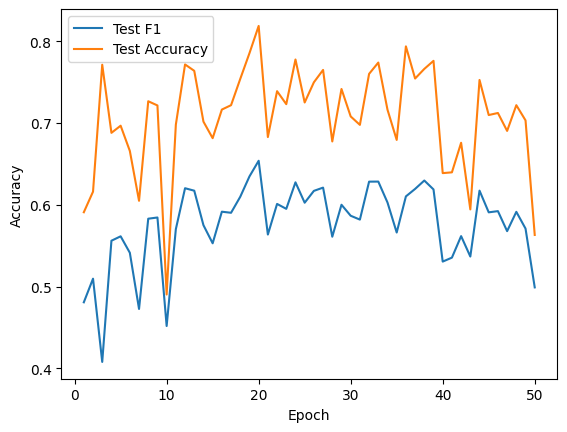

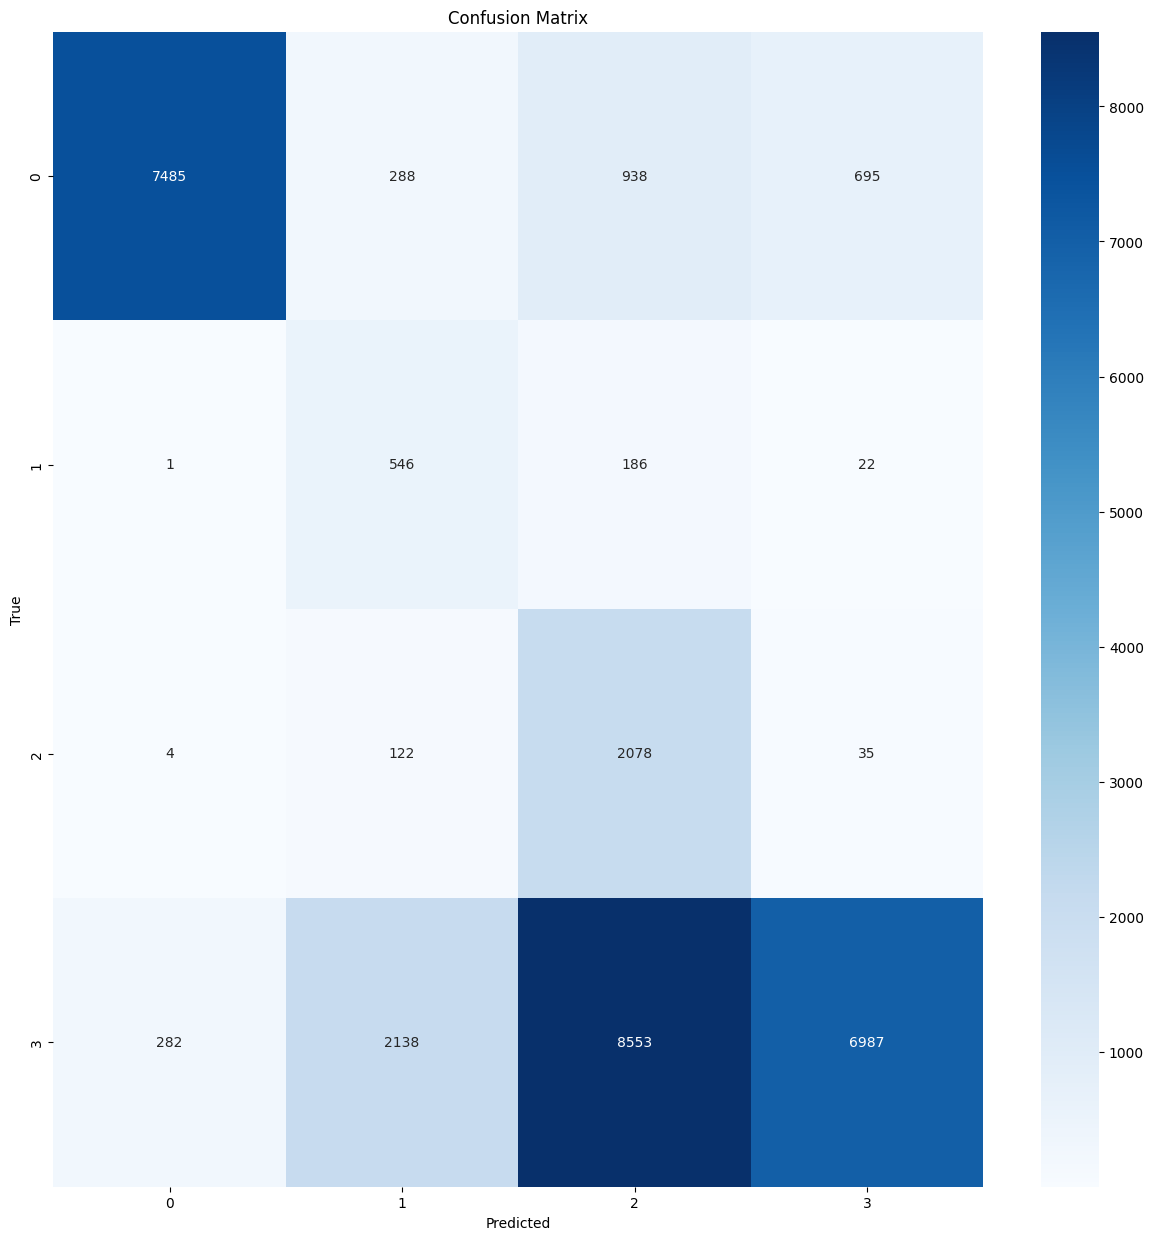

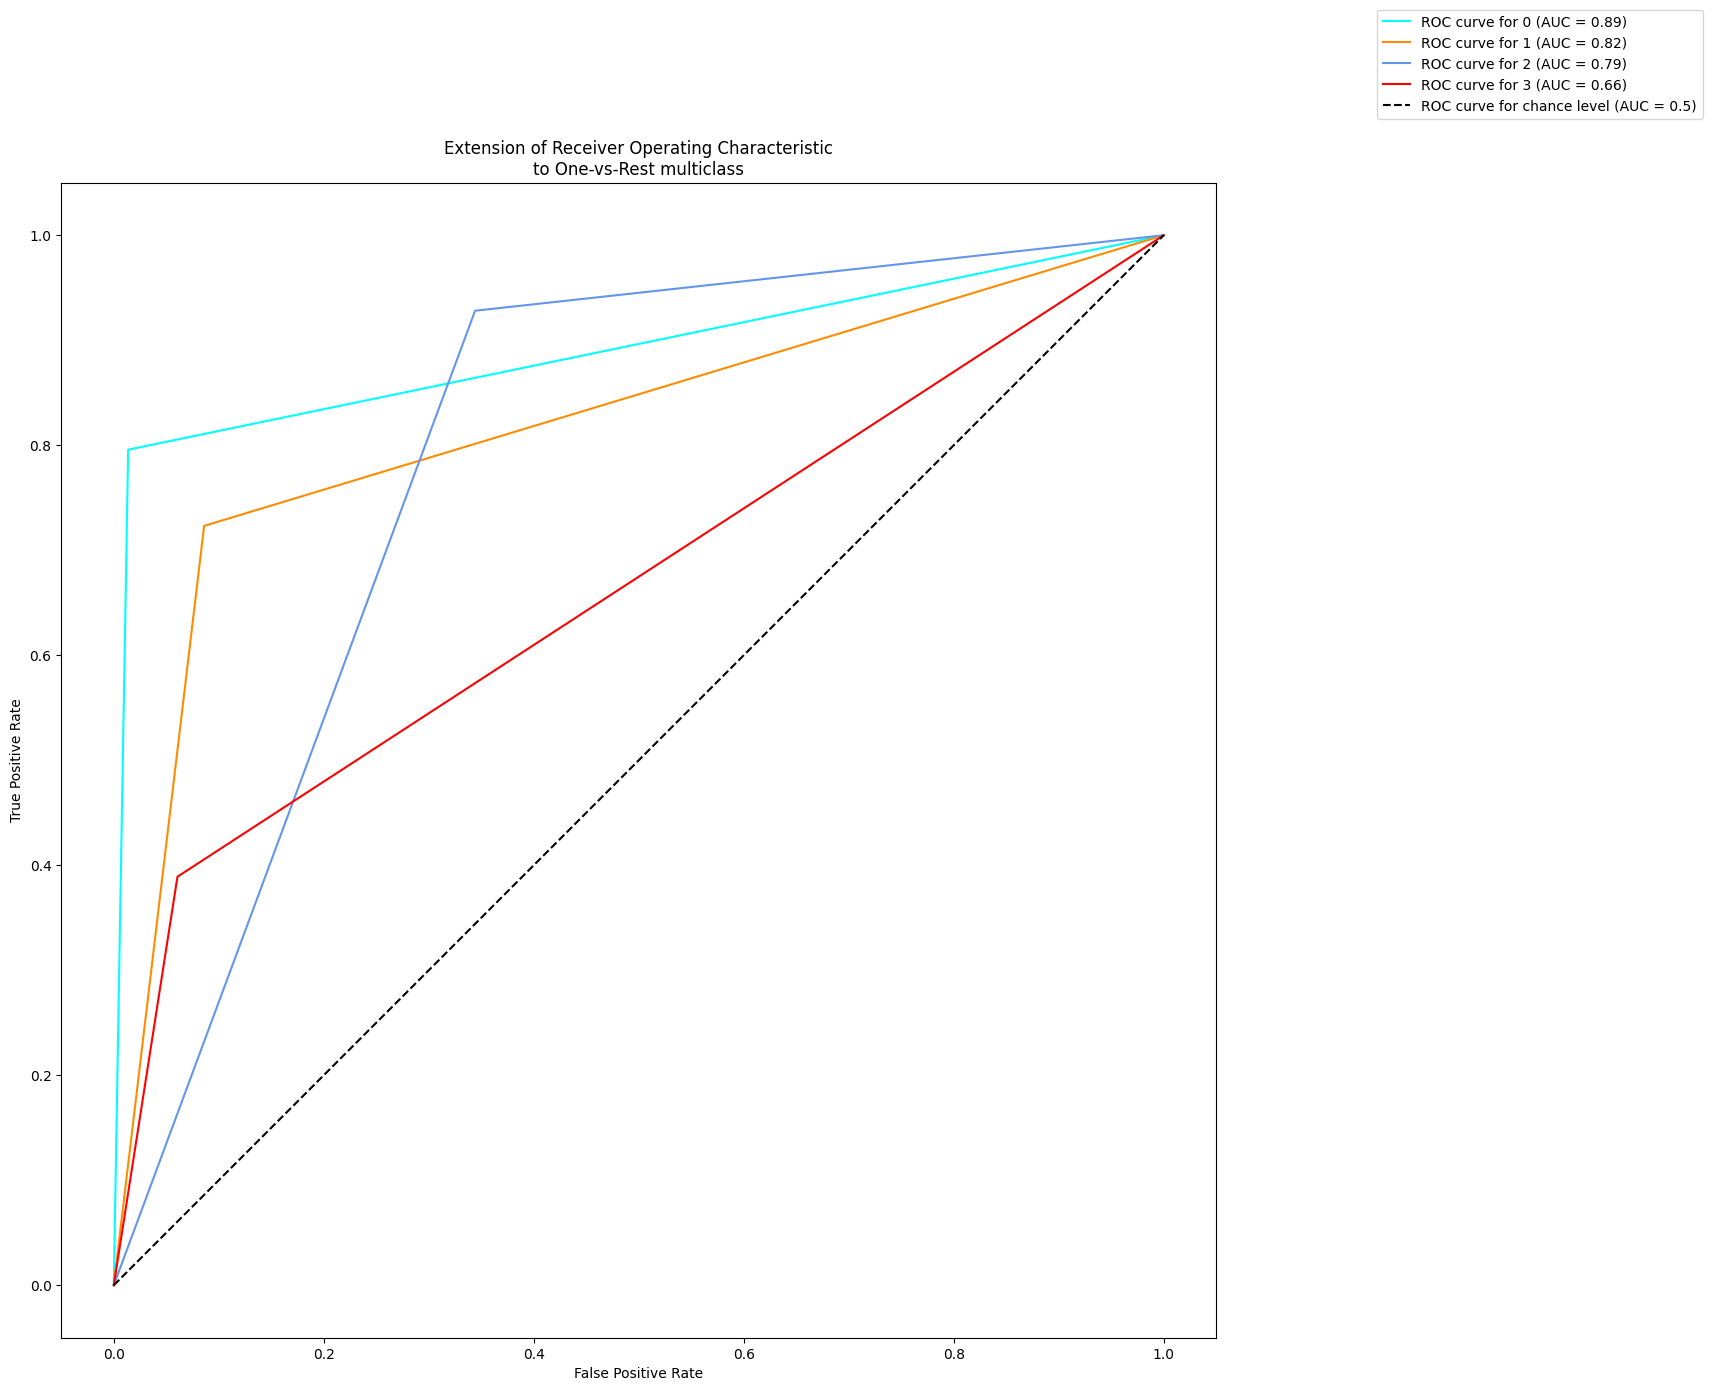

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      9406
           1       0.18      0.72      0.28       755
           2       0.18      0.93      0.30      2239
           3       0.90      0.39      0.54     17960

    accuracy                           0.56     30360
   macro avg       0.55      0.71      0.50     30360
weighted avg       0.85      0.56      0.62     30360



(0.5631093544137022,
 0.8498853951607723,
 0.5631093544137022,
 0.6206193288464208,
 {'Acc': {'Acc': 0.8186758893280632,
   'F1': 0.653812709521657,
   'Auc': 0.8020256120637199,
   'Epoch': 20,
   'Auc_Per_Class': array([0.92471574, 0.71980301, 0.73040944, 0.83317426])},
  'Macro-F1': {'Acc': 0.8186758893280632,
   'F1': 0.653812709521657,
   'Auc': 0.8020256120637199,
   'Epoch': 20,
   'Auc_Per_Class': array([0.92471574, 0.71980301, 0.73040944, 0.83317426])},
  'AUC': {'Acc': 0.7526021080368906,
   'F1': 0.6172819127167299,
   'Auc': 0.8475688563246702,
   'Epoch': 44,
   'Auc_Per_Class': array([0.92310987, 0.86295003, 0.80904498, 0.79517054])}})

In [7]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=50, multilabel=multilabel, report=True)

Training Late Fusion Model:
The number of parameters of the model are: 312196
Epoch 1/50 - Test Accuracy: 0.7139, macro-f1: 0.5803, macro-AUC: 0.8293
Epoch 1/50 - Training Time: 8.79 seconds | Inference Time: 2.73 seconds
Epoch 2/50 - Test Accuracy: 0.7061, macro-f1: 0.5850, macro-AUC: 0.8403
Epoch 2/50 - Training Time: 8.65 seconds | Inference Time: 2.31 seconds
Epoch 3/50 - Test Accuracy: 0.7653, macro-f1: 0.6281, macro-AUC: 0.8416
Epoch 3/50 - Training Time: 9.32 seconds | Inference Time: 2.43 seconds
Epoch 4/50 - Test Accuracy: 0.8051, macro-f1: 0.6541, macro-AUC: 0.8451
Epoch 4/50 - Training Time: 9.40 seconds | Inference Time: 2.39 seconds
Epoch 5/50 - Test Accuracy: 0.7629, macro-f1: 0.6297, macro-AUC: 0.8530
Epoch 5/50 - Training Time: 8.88 seconds | Inference Time: 2.42 seconds
Epoch 6/50 - Test Accuracy: 0.7749, macro-f1: 0.6435, macro-AUC: 0.8421
Epoch 6/50 - Training Time: 8.63 seconds | Inference Time: 2.78 seconds
Epoch 7/50 - Test Accuracy: 0.7588, macro-f1: 0.6294, macr

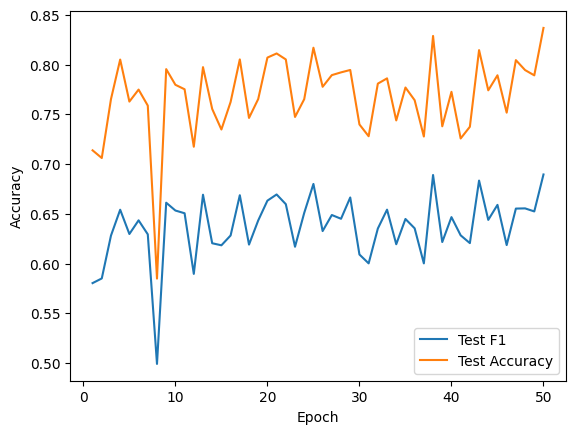

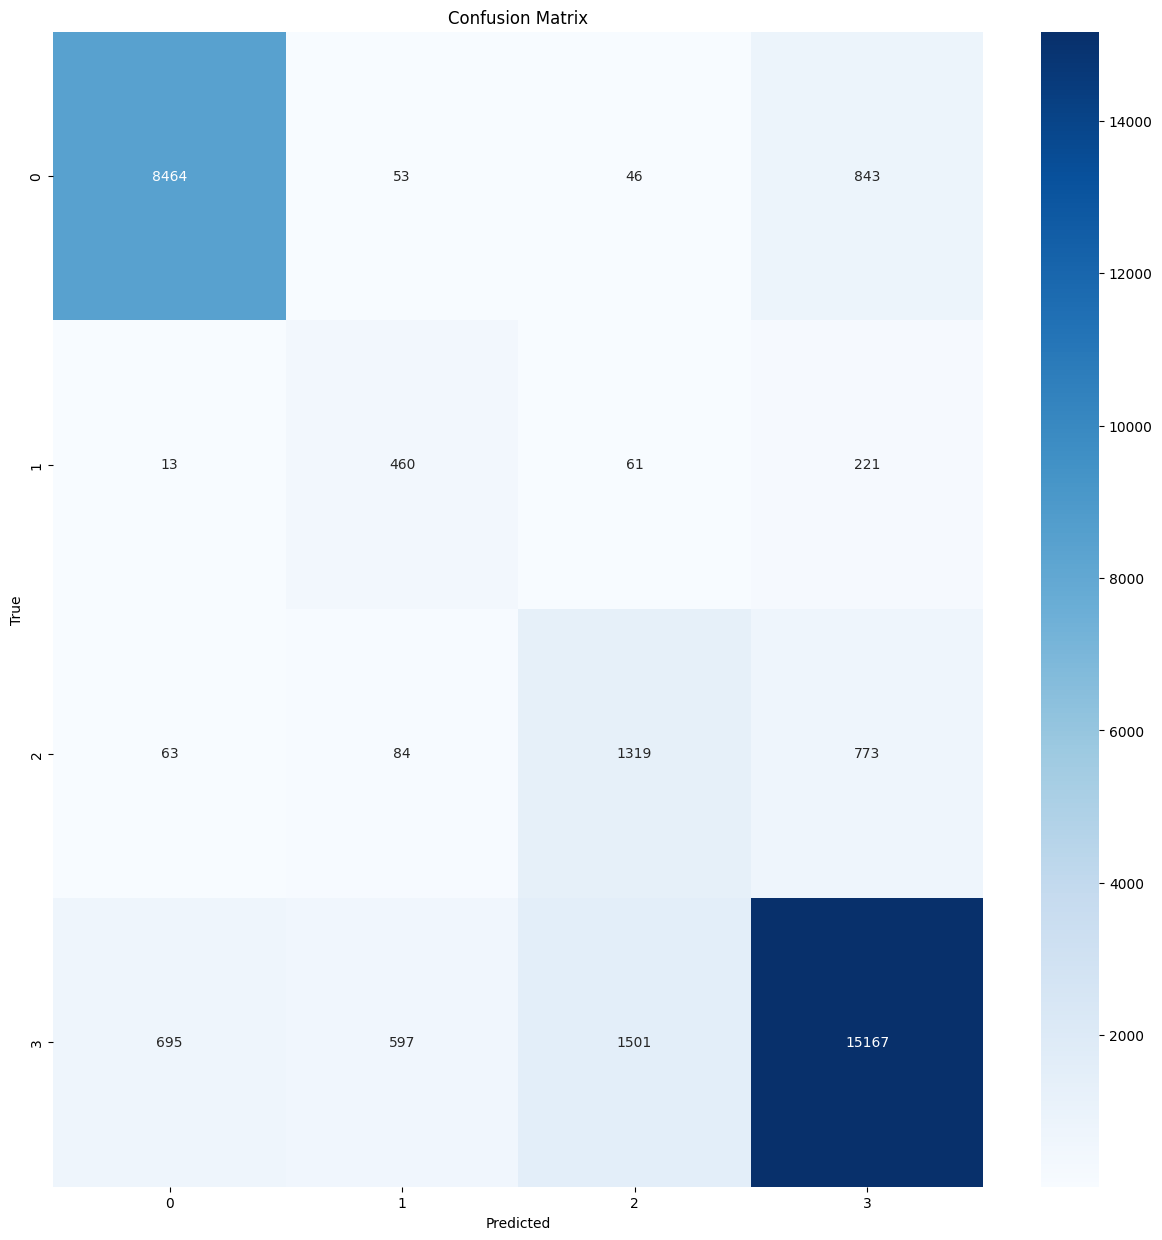

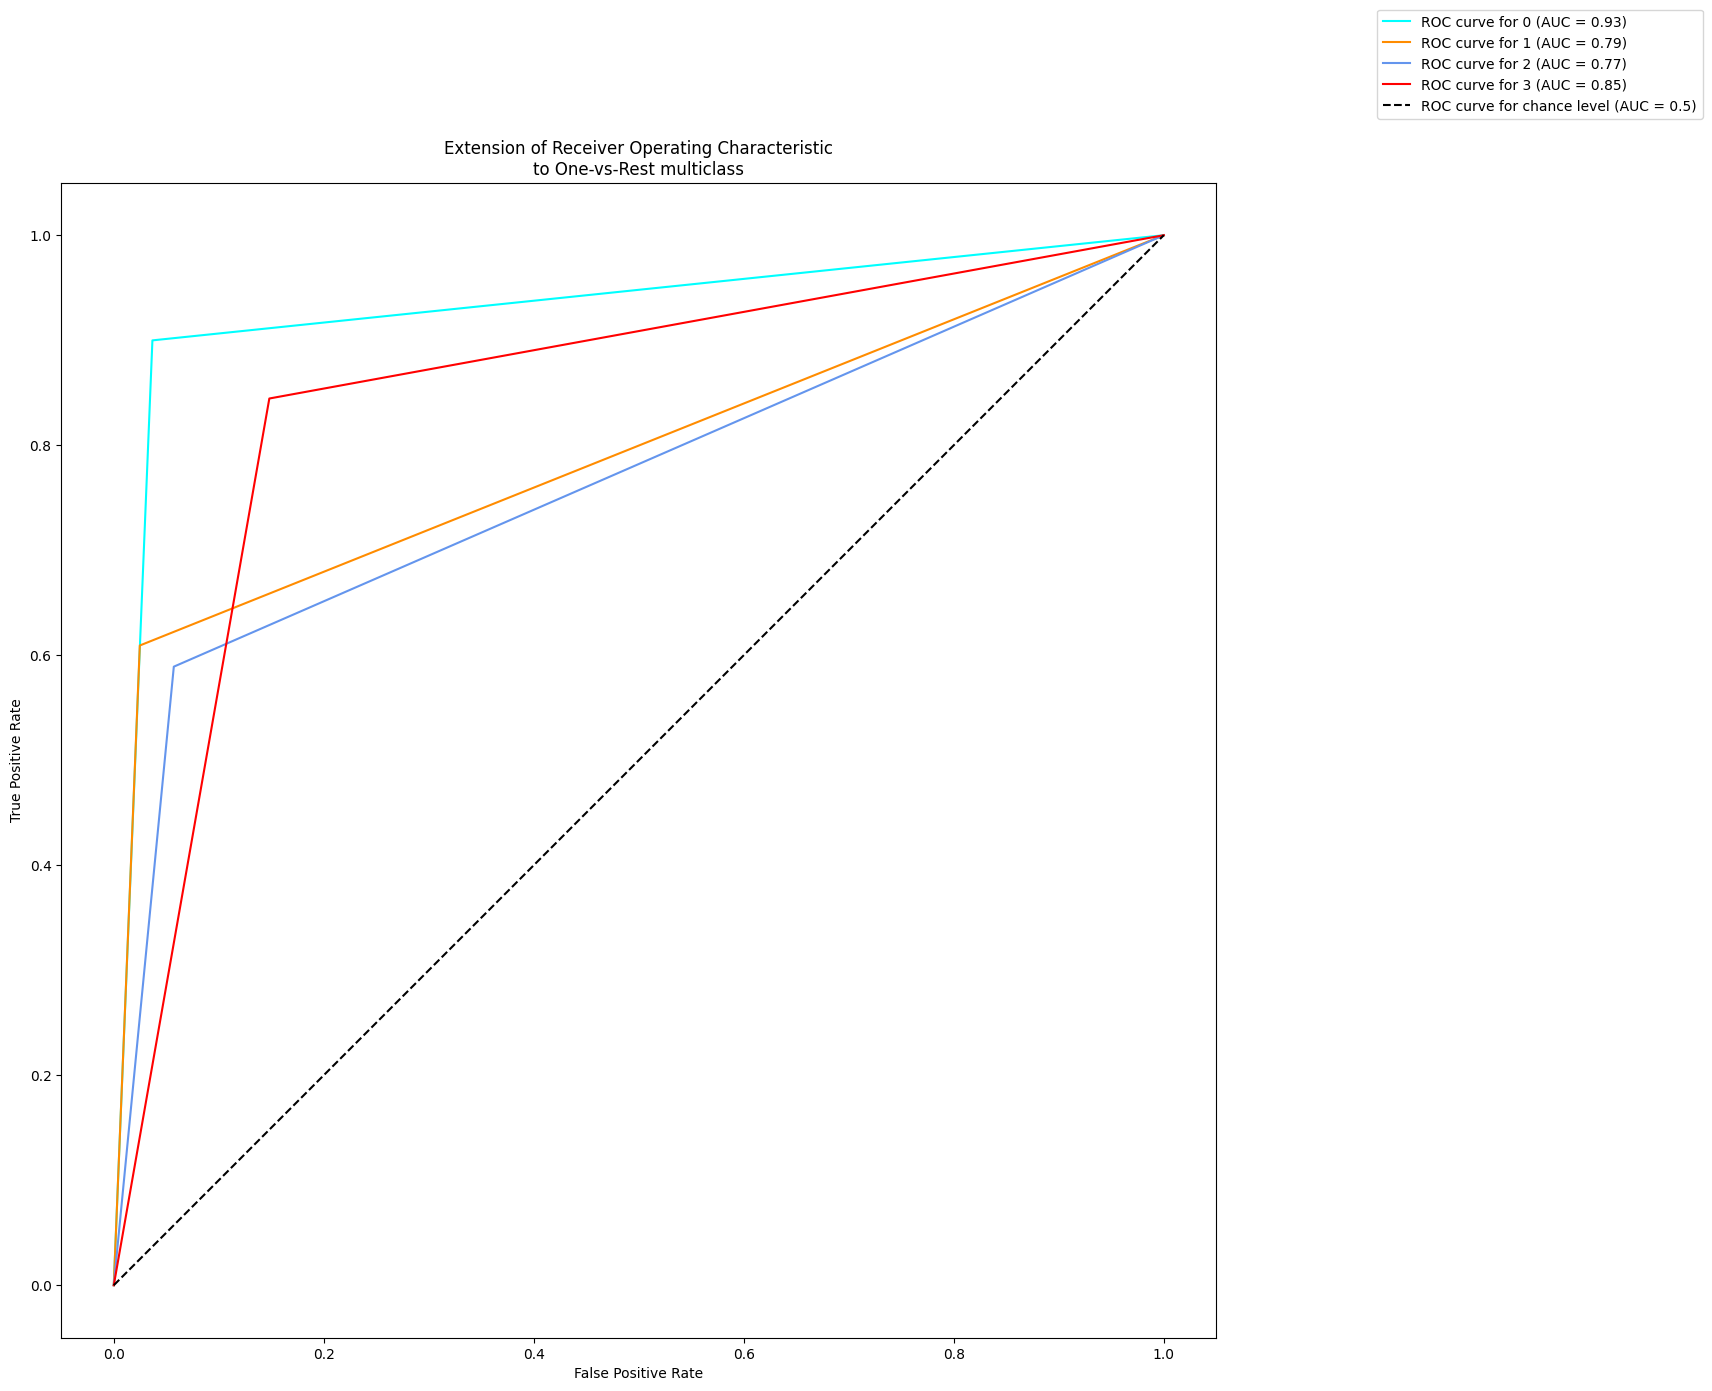

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      9406
           1       0.39      0.61      0.47       755
           2       0.45      0.59      0.51      2239
           3       0.89      0.84      0.87     17960

    accuracy                           0.84     30360
   macro avg       0.66      0.74      0.69     30360
weighted avg       0.85      0.84      0.84     30360



(0.8369565217391305,
 0.85442292516298,
 0.8369565217391305,
 0.8439746656937873,
 {'Acc': {'Acc': 0.8369565217391305,
   'F1': 0.6895918364213958,
   'Auc': 0.8344747612463017,
   'Epoch': 50,
   'Auc_Per_Class': array([0.93152814, 0.79223921, 0.76596041, 0.84817129])},
  'Macro-F1': {'Acc': 0.8369565217391305,
   'F1': 0.6895918364213958,
   'Auc': 0.8344747612463017,
   'Epoch': 50,
   'Auc_Per_Class': array([0.93152814, 0.79223921, 0.76596041, 0.84817129])},
  'AUC': {'Acc': 0.7588274044795784,
   'F1': 0.6293930253298369,
   'Auc': 0.8558207689402582,
   'Epoch': 7,
   'Auc_Per_Class': array([0.93338016, 0.86196745, 0.82703292, 0.80090254])}})

In [8]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=50, multilabel=multilabel, report=True)